# data cleaning

In [1]:
import numpy as np
import pandas as pd
import pickle
import re

import jieba
from pycantonese.word_segmentation import Segmenter
import pycantonese

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,  TfidfTransformer

import hmmlearn as hmmlearn
from hmmlearn import hmm
from hmmlearn.base import ConvergenceMonitor

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']

import matplotlib.font_manager
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import dataset
df_msg_valid = pd.read_excel('../data/good_bad_chat_history_total_20240117.xlsx')

In [20]:
# describe the distribution of total message exchange count
df_pp_count = df_msg_valid.drop_duplicates(subset=['conversationId'])[['conversationId', 'max_pp']]
df_pp_count_des = df_pp_count.describe()

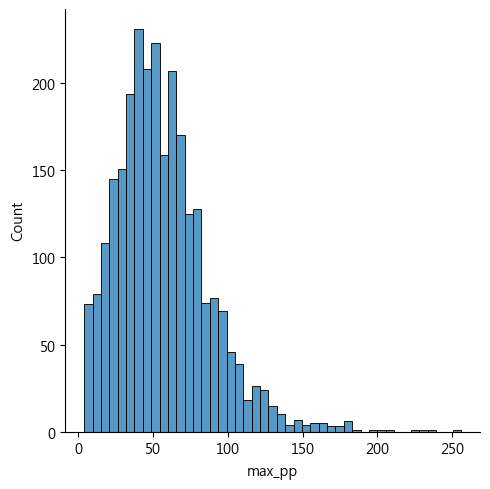

In [21]:
# draw distribution of total message exchange count
sns.displot(df_pp_count, x='max_pp')

In [22]:
# calculate Interquantile Range
print(df_pp_count_des.loc['75%','max_pp']+1.5*(df_pp_count_des.loc['75%','max_pp']-df_pp_count_des.loc['25%','max_pp']))

131.5


In [23]:
# select sessions with total message exchange count no less than 4 and remove outliers using 1.5*IQR to ensure data balance
valid_convId_pp = df_pp_count[(df_pp_count['max_pp']>=4)&(df_pp_count['max_pp']<=132)]['conversationId'].tolist()
len(valid_convId_pp)

2589

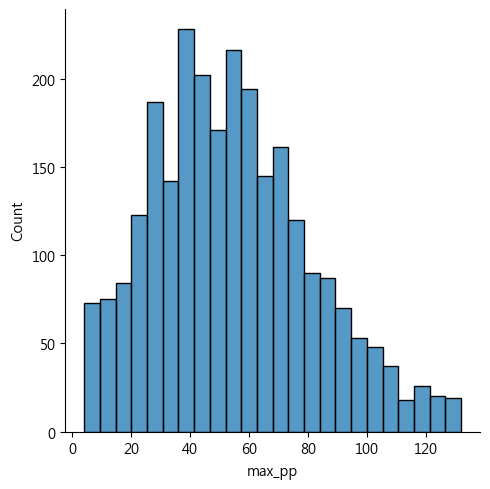

In [24]:
# draw distribution of total message exchange count after removing outliers
df_pp = df_msg_valid[(df_msg_valid['conversationId'].isin(valid_convId_pp))].drop_duplicates(subset=['conversationId'])
sns.displot(df_pp, x='max_pp')

In [25]:
# select session history after removing outliers
df_msg_validd = df_msg_valid[(df_msg_valid['conversationId'].isin(valid_convId_pp))]
df_msg_validd.reset_index(inplace=True, drop=True)

In [26]:
# for simplicity, label more satisfying sessions as 'good' & less satisftying sessions as 'bad'
good_bad_count = df_msg_validd.drop_duplicates(subset=['conversationId'])
good_bad_count['quality'].value_counts()

good    1993
bad      596
Name: quality, dtype: int64

# data processing

In [27]:
df_msg_valid = df_msg_validd.copy()

In [28]:
# as the dataset is imported from an excel file, the msg_token_list is not in list format. Re-form the msg_token_list as list.
df_msg_valid['msg_token_list'] = None
for i in range(len(df_msg_valid['msg_token'])):
    df_msg_valid['msg_token_list'][i] = df_msg_valid['msg_token'][i].split(' ')

In [29]:
# calculate the percentage of each message exchange
df_msg_valid=df_msg_valid.assign(pp_percentage=df_msg_valid['pp']/df_msg_valid['max_pp'])

In [30]:
# split sessions into five stages with estimated percentage. HMM will automatically adjust and converge eventually.
def df_label_category(df, cat):
    labels = np.arange(len(cat)-1)
    category = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    df['pp_category'] = pd.cut(df['pp_percentage'], labels=labels, bins=category, include_lowest=True)
    return df

n_stage=6
df_msg_valid=df_msg_valid.pipe(df_label_category, np.linspace(0, 1 , n_stage) )
df_msg_valid['pp_category'] = df_msg_valid['pp_category'].fillna(0)

In [31]:
df_msg_valid = df_msg_valid[['conversationId', 'from_whom', 'datetime', 'msg_replace', 'msg_token', 'msg_token_list', 'pp', 'max_pp', 'pp_percentage', 'pp_category']]

In [32]:
# add 'H' to each word in each help-seeker message and 'C' to each word in each counselor message to distinguish two conversationists
for i in range(len(df_msg_valid['msg_token_list'])):
    if df_msg_valid['from_whom'][i] == True:
        for j in range(len(df_msg_valid['msg_token_list'][i])):
            df_msg_valid['msg_token_list'][i][j] = 'H' + df_msg_valid['msg_token_list'][i][j]
    else:
        for j in range(len(df_msg_valid['msg_token_list'][i])):
            df_msg_valid['msg_token_list'][i][j] = 'C' + df_msg_valid['msg_token_list'][i][j]

In [33]:
# re-organize the token list of each message
df_msg_valid['msg_token'] = [' '.join(i) for i in df_msg_valid['msg_token_list']]

# HMM training

## word filtering based on TF-IDF score

In [34]:
# instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(token_pattern='\\b\\w+\\b', min_df=2)

# fit and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(df_msg_valid['msg_token'])

# get feature names and their corresponding TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = np.asarray(tfidf_matrix.sum(axis=0)).flatten()

# create a DataFrame for TF-IDF scores
tfidf_df = pd.DataFrame({'word': feature_names, 'score': tfidf_scores})

In [35]:
tfidf_df['score'].describe()

count    26017.000000
mean        12.478879
std         50.606572
min          0.097755
25%          1.431256
50%          2.475009
75%          6.437645
max       1927.108042
Name: score, dtype: float64

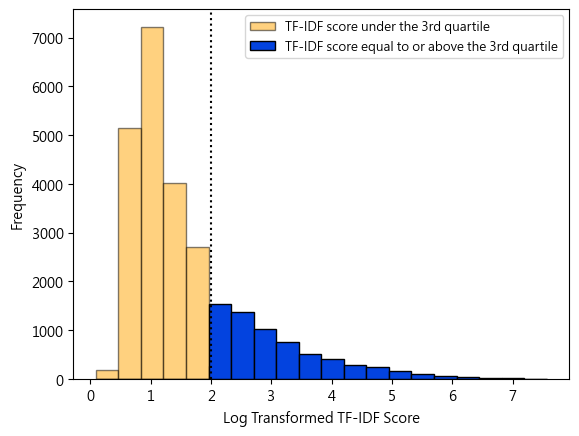

In [36]:
norm_tf_idf = tfidf_df.copy()

# Log transformation to reduce the skewness
norm_tf_idf['log_score'] = np.log1p(norm_tf_idf['score'])

# Determine the range of the log-transformed scores
min_value = norm_tf_idf['log_score'].min()
max_value = norm_tf_idf['log_score'].max()

# Define the number of bins
num_bins = 20

# Create equally spaced bin edges
bin_edges = np.linspace(min_value, max_value, num_bins + 1)

threshold=6.44

# Plotting the histogram for TF-IDF scores less than or equal to the threshold
plt.hist(norm_tf_idf[norm_tf_idf['score'] <= threshold]['log_score'], bins=bin_edges, color='orange', edgecolor='black', alpha=0.5, label='TF-IDF score under the 3rd quartile')

# Plotting the histogram for TF-IDF scores greater than the threshold
plt.hist(norm_tf_idf[norm_tf_idf['score'] > threshold]['log_score'], bins=bin_edges, color='#0343DF', edgecolor='black', alpha=1, label='TF-IDF score equal to or above the 3rd quartile')

# Add a vertical line at the threshold (6.64)
plt.axvline(np.log1p(threshold), color='black', linestyle='dotted', linewidth=1.5)

# Add labels and title
plt.xlabel('Log Transformed TF-IDF Score')
plt.ylabel('Frequency')

# Add legend
plt.legend(fontsize=9)

# Show the plot
plt.show()

In [37]:
# filter based on a score threshold (3rd quantile)
threshold = tfidf_df['score'].describe()['75%']

low_tfidf_words = list(tfidf_df.loc[tfidf_df['score']<threshold]['word'])

In [38]:
# calculate word occrrence with removal of words with low TF-IDF score
cv = CountVectorizer(min_df = 2, max_df = 1.0, token_pattern ='\\b\\w+\\b', stop_words = low_tfidf_words)
cv.fit(df_msg_valid['msg_token'])
X = cv.transform(df_msg_valid['msg_token'])
X

<198316x6505 sparse matrix of type '<class 'numpy.int64'>'
	with 565154 stored elements in Compressed Sparse Row format>

In [39]:
# extract feature names from the fitted CountVectorizer
feature_names_cv = cv.get_feature_names_out()

# sum the word occurrences in the matrix to get their total counts
word_counts = np.asarray(X.sum(axis=0)).flatten()

# create a DataFrame with words and their corresponding counts
word_count_df = pd.DataFrame({'word': feature_names_cv, 'count': word_counts})
word_count_df.sort_values(by=['count'], ascending=False).head()

,word,count
1203,c感覺,5280
2646,c需要,3752
4891,h朋友,3566
230,c你好,3385
1144,c情緒,3202


## remove messages with no bag-of-words

In [40]:
for i in range(21):
    print("%s out of %s BoW counts has greater than %s occurence"%((X.sum(axis=1)>i).sum(axis=0)[0,0], X.shape[0],i))

188823 out of 198316 BoW counts has greater than 0 occurence
130307 out of 198316 BoW counts has greater than 1 occurence
84923 out of 198316 BoW counts has greater than 2 occurence
55271 out of 198316 BoW counts has greater than 3 occurence
35837 out of 198316 BoW counts has greater than 4 occurence
24127 out of 198316 BoW counts has greater than 5 occurence
16511 out of 198316 BoW counts has greater than 6 occurence
11555 out of 198316 BoW counts has greater than 7 occurence
8286 out of 198316 BoW counts has greater than 8 occurence
6043 out of 198316 BoW counts has greater than 9 occurence
4386 out of 198316 BoW counts has greater than 10 occurence
3233 out of 198316 BoW counts has greater than 11 occurence
2490 out of 198316 BoW counts has greater than 12 occurence
1919 out of 198316 BoW counts has greater than 13 occurence
1494 out of 198316 BoW counts has greater than 14 occurence
1206 out of 198316 BoW counts has greater than 15 occurence
989 out of 198316 BoW counts has greater

In [41]:
## remove conversation without any BoW inside
threshold = 1
X_final = X[np.where(X.sum(axis=1) > threshold)[0],:]
df_msg_valid_final = df_msg_valid.iloc[np.where(X.sum(axis=1) > threshold)[0],:]
df_msg_valid_final.reset_index(inplace = True, drop = True)

In [42]:
X_final

<130307x6505 sparse matrix of type '<class 'numpy.int64'>'
	with 506638 stored elements in Compressed Sparse Row format>

# prepare emission probability matrix

In [43]:
emission=pd.DataFrame(X_final.toarray())
df_msg_valid_final.pp_category=df_msg_valid_final.pp_category.astype(int)
emission["stage"]=df_msg_valid_final.pp_category

In [44]:
emission=emission.groupby('stage').sum()

In [45]:
emission+=1

In [46]:
emission

,0,1,2,3,4,5,6,7,8,9,...,6495,6496,6497,6498,6499,6500,6501,6502,6503,6504
stage,,,,,,,,,,,,,,,,,,,,,
0,20,4,34,30,5,1,2,1,16,1,...,87,1,49,27,1,5,27,11,14,6
1,23,4,36,59,11,2,2,1,26,2,...,65,3,50,5,8,11,26,15,26,3
2,21,3,48,41,11,3,7,1,29,3,...,55,7,33,9,4,7,20,8,31,6
3,16,4,81,49,16,3,2,1,30,5,...,28,2,24,6,2,7,25,6,27,4
4,16,9,55,71,42,8,5,14,43,6,...,11,1,11,4,3,6,18,4,28,2


# train HMM

In [390]:
df_emission_scale=emission.apply(lambda x:x/emission.sum(axis=1),axis=0)

## 5 stage HMM
chmm=hmmlearn.hmm.PoissonHMM(n_components=5, params ='tl', init_params='', n_iter=1000, implementation ='log' ,transmat_prior=10, lambdas_prior=10)
chmm.startprob_=np.array([1, 0, 0, 0, 0])

chmm.transmat_ = np.array([[0.265, 0.457, 0.251, 0.024, 0.003],
                           [0.023, 0.473, 0.465, 0.038, 0.001],
                           [0.057, 0.273, 0.437, 0.231, 0.002],
                           [0.   , 0.021, 0.694, 0.167, 0.118],
                           [0.   , 0.   , 0.   , 0.   , 1.   ]])


chmm.lambdas_=df_emission_scale

In [391]:
df_len=df_msg_valid_final.groupby("conversationId").count()['pp_category']

In [392]:
np.round(chmm.transmat_, 3)

array([[0.265, 0.457, 0.251, 0.024, 0.003],
       [0.023, 0.473, 0.465, 0.038, 0.001],
       [0.057, 0.273, 0.437, 0.231, 0.002],
       [0.   , 0.021, 0.694, 0.167, 0.118],
       [0.   , 0.   , 0.   , 0.   , 1.   ]])

In [393]:
chmm.fit(X_final.toarray(), df_len)

PoissonHMM(init_params='', lambdas_prior=10, n_components=5, n_iter=1000,
           params='tl', random_state=RandomState(MT19937) at 0x1C4A1229940,
           transmat_prior=10)

In [394]:
# model convergence monitor
chmm.monitor_

ConvergenceMonitor(
    history=[-4174266.837832452, -3749748.4407380978, -3671547.4079984874, -3628039.0236734753, -3606610.851276373, -3597639.460669781, -3594193.2084335703, -3592448.4579578666, -3591291.3108220976, -3590314.366159064, -3589438.6114415494, -3588579.2365038986, -3587787.0708207893, -3587098.3434860944, -3586632.9615892824, -3586340.0521303704, -3586150.7052111397, -3585984.35095844, -3585861.385217109, -3585753.5064142914, -3585694.1299665286, -3585655.36868225, -3585619.8561511855, -3585590.4859953285, -3585549.7365797907, -3585489.5843580742, -3585460.0880607646, -3585434.963423579, -3585418.9050449524, -3585409.4741086154, -3585400.609758945, -3585393.9697413812, -3585386.645907354, -3585380.4160801587, -3585374.0286362018, -3585368.051037104, -3585360.797799879, -3585354.5597704262, -3585350.3094855943, -3585345.0141334394, -3585339.7741993703, -3585337.7117303656, -3585336.640431036, -3585335.9323876738, -3585335.434800234, -3585335.0591634903, -3585334.74050369

In [574]:
# transition probability when model converged
np.set_printoptions(suppress=True, precision=3)
np.round(chmm.transmat_, 3)

array([[0.445, 0.393, 0.142, 0.019, 0.001],
       [0.019, 0.488, 0.457, 0.036, 0.   ],
       [0.044, 0.55 , 0.385, 0.02 , 0.001],
       [0.   , 0.401, 0.176, 0.414, 0.009],
       [0.   , 0.   , 0.   , 0.   , 1.   ]])

# keywords visualization

In [444]:
# get words with their emission probability after model convergence
boW_prob = pd.DataFrame(chmm.lambdas_, columns=cv.get_feature_names_out()).transpose()

# get words with their initialized emission probability
boW_prob_baseline=pd.DataFrame(df_emission_scale.to_numpy(),columns=cv.get_feature_names_out()).transpose()

In [434]:
boW_prob.sort_values(0, ascending=False).head(5)[0]

c輔導員    0.248303
c稱呼     0.154585
c你好     0.141953
c當值     0.129331
c請問     0.083208
Name: 0, dtype: float64

In [435]:
boW_prob.sort_values(1, ascending=False).head(5)[1]

h朋友    0.048909
h問題    0.038126
h情緒    0.035553
h之前    0.034679
h工作    0.028188
Name: 1, dtype: float64

In [436]:
boW_prob.sort_values(2, ascending=False).head(5)[2]

c情緒    0.052284
c明白    0.040346
c擔心    0.039121
c情況    0.038158
c影響    0.037444
Name: 2, dtype: float64

In [438]:
boW_prob.sort_values(3, ascending=False).head(5)[3]

c社工    0.254608
c服務    0.204136
c學校    0.119822
c聯絡    0.091567
c轉介    0.067428
Name: 3, dtype: float64

In [446]:
boW_prob.sort_values(4, ascending=False).head(5)[4]

c希望    0.051725
c休息    0.039724
c傾到    0.030501
h謝謝    0.023540
c意見    0.022206
Name: 4, dtype: float64

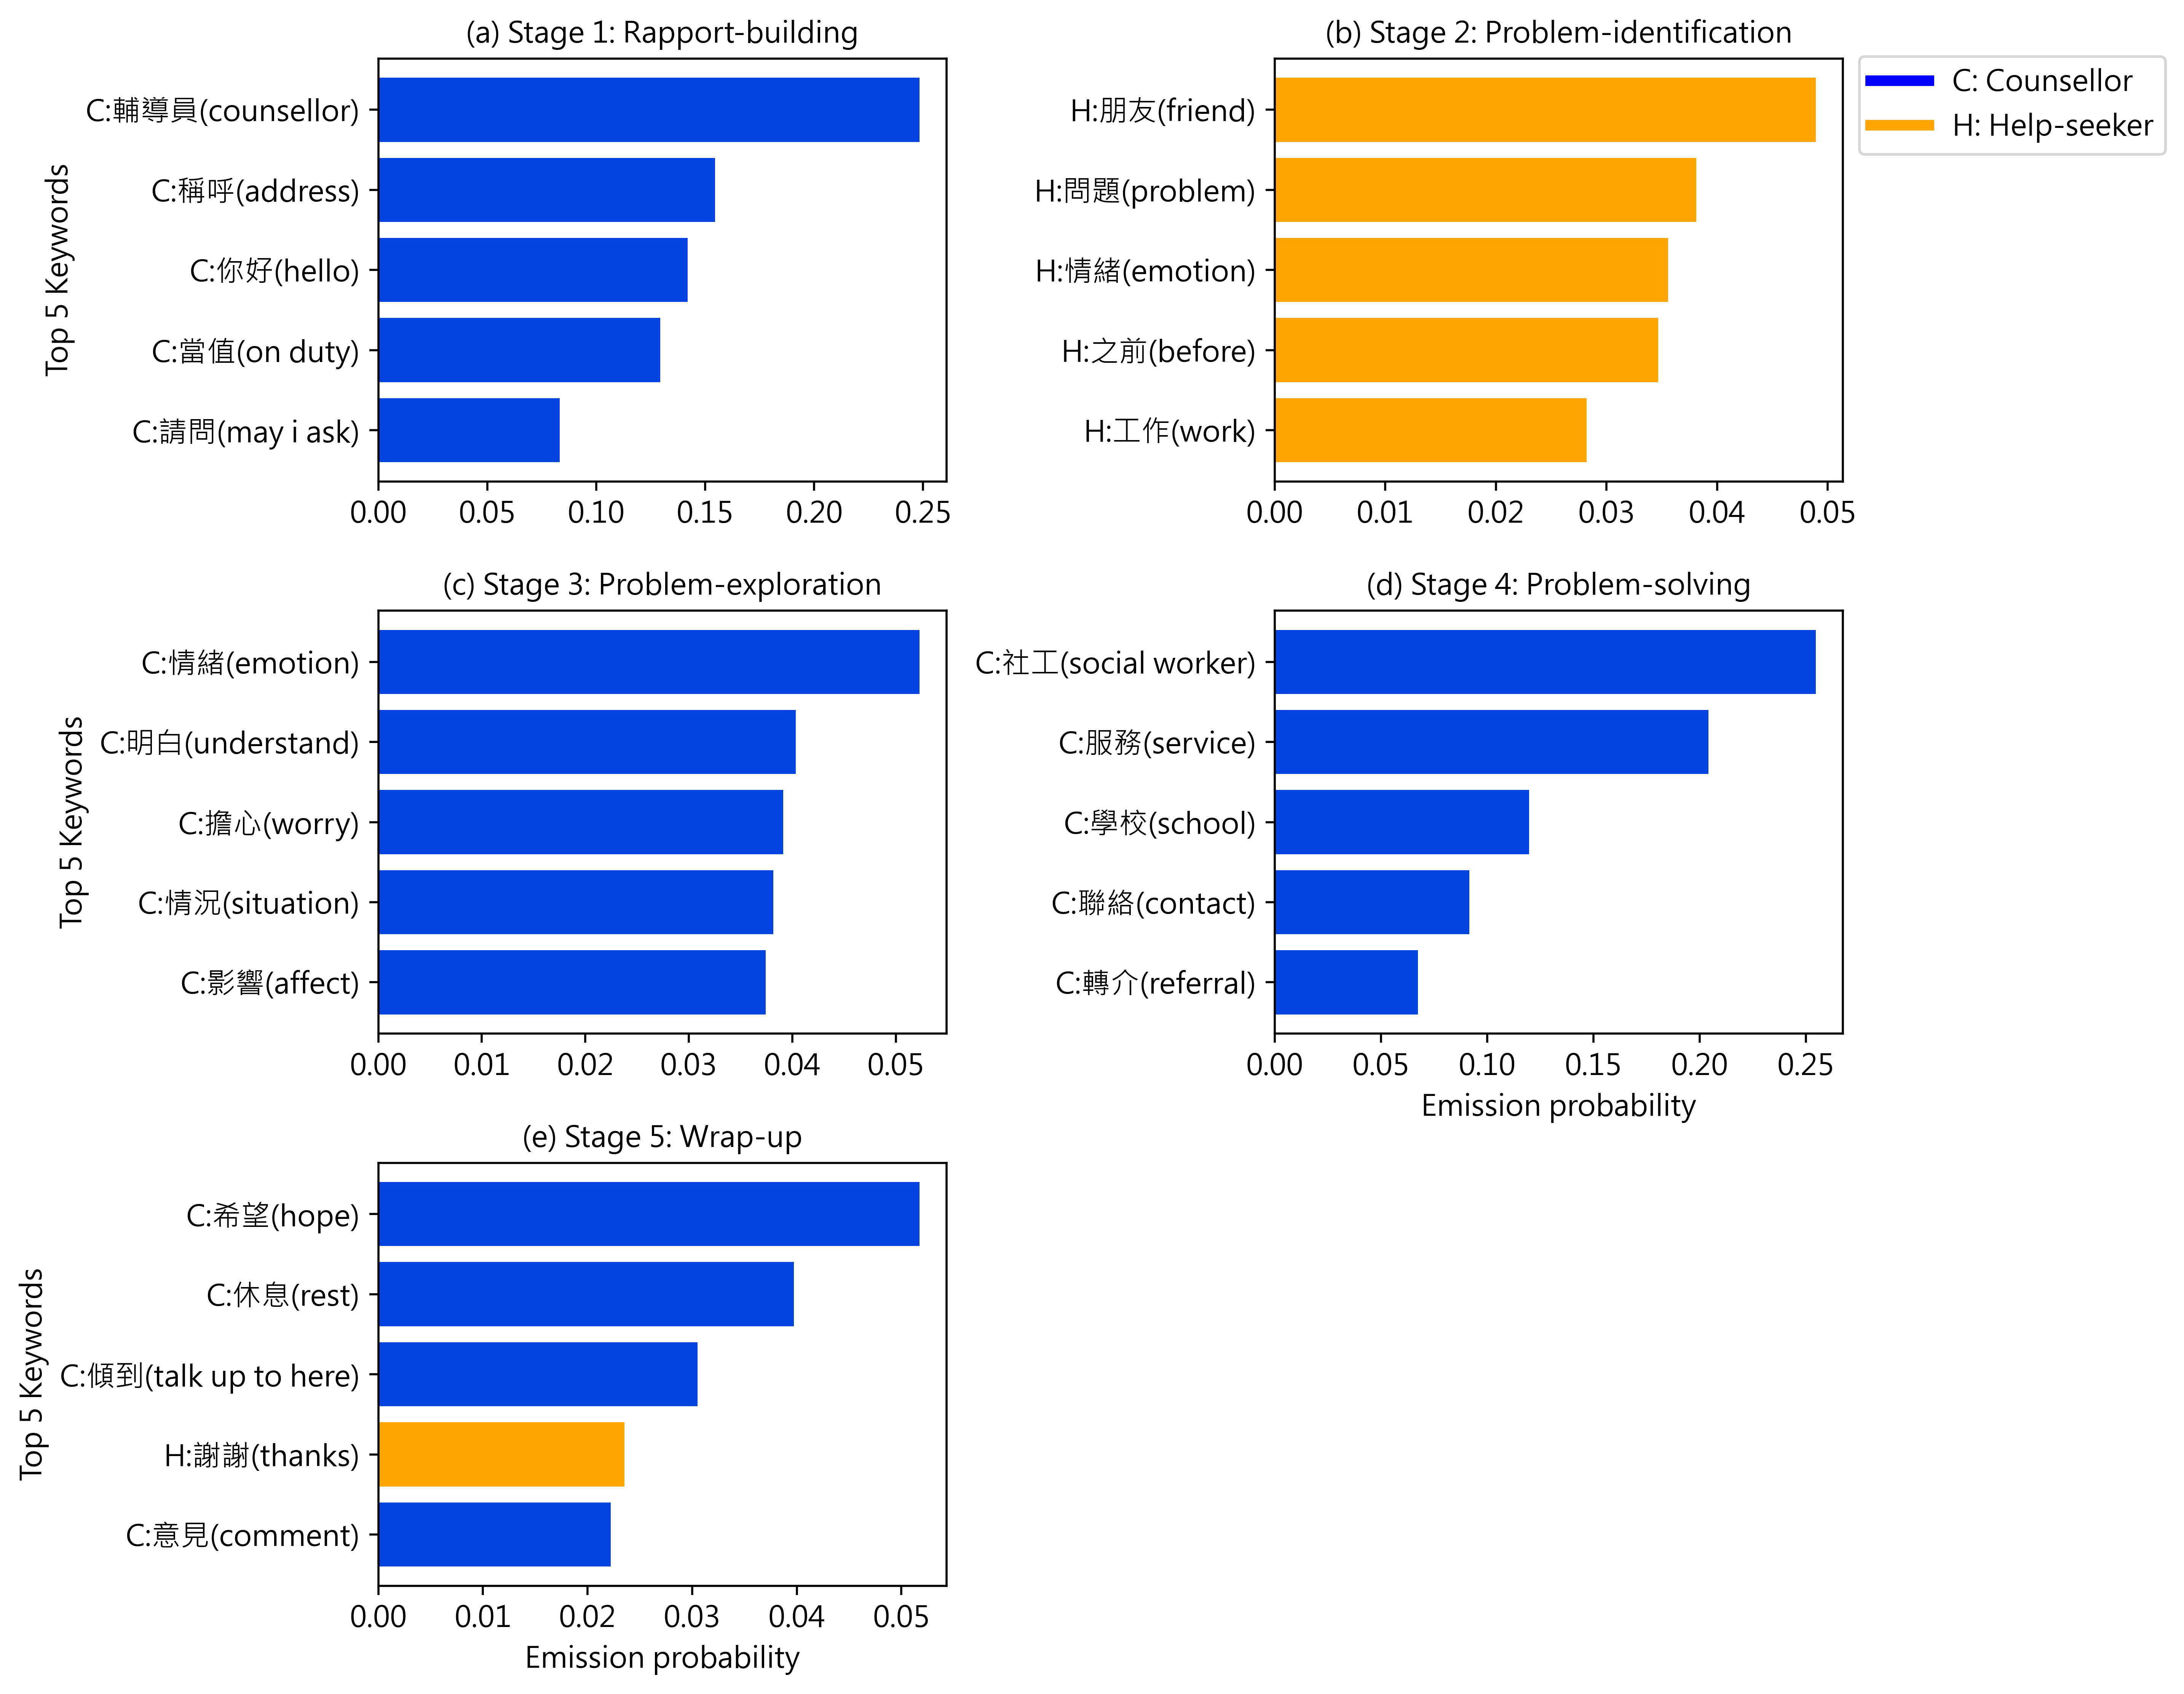

In [47]:
import matplotlib.pyplot as plt

# Adjusting the code to combine the five plots into a single figure with a 3x2 grid layout
plt.rcParams['figure.dpi'] = 500
fig, axes = plt.subplots(3, 2, figsize=(10, 9))  # Adjusting the figure size for better visibility

# Data for the plots
labels = [
    ['C:輔導員(counsellor)', 'C:稱呼(address)', 'C:你好(hello)', 'C:當值(on duty)', 'C:請問(may i ask)'],
    ['H:朋友(friend)', 'H:問題(problem)', 'H:情緒(emotion)', 'H:之前(before)', 'H:工作(work)'],
    ['C:情緒(emotion)', 'C:明白(understand)', 'C:擔心(worry)', 'C:情況(situation)', 'C:影響(affect)'],
    ['C:社工(social worker)', 'C:服務(service)', 'C:學校(school)', 'C:聯絡(contact)', 'C:轉介(referral)'],
    ['C:希望(hope)', 'C:休息(rest)', 'C:傾到(talk up to here)', 'H:謝謝(thanks)', 'C:意見(comment)']
]

values = [
    [0.248303, 0.154585, 0.141953, 0.129331, 0.083208],
    [0.048909, 0.038126, 0.035553, 0.034679, 0.028188],
    [0.052284, 0.040346, 0.039121, 0.038158, 0.037444],
    [0.254608, 0.204136, 0.119822, 0.091567, 0.067428],
    [0.051725, 0.039724, 0.030501, 0.023540, 0.022206]
]

titles = [
    '(a) Stage 1: Rapport-building',
    '(b) Stage 2: Problem-identification',
    '(c) Stage 3: Problem-exploration',
    '(d) Stage 4: Problem-solving',
    '(e) Stage 5: Wrap-up'
]

fontsize_set = 11

# Creating the individual plots
for i in range(5):
    ax = axes[i//2, i%2]
    colors = ['#0343DF' if 'C:' in label else 'orange' for label in labels[i]]  # Assign colors based on 'C:' or 'H:'
    ax.barh(labels[i][::-1], values[i][::-1], color=colors[::-1], alpha=1)  # Reverse colors to match reversed labels
    ax.set_title(titles[i], fontsize=fontsize_set)
    if i == 3 or i == 4:
        ax.set_xlabel('Emission probability', fontsize=fontsize_set)
    if i % 2 == 0:
        ax.set_ylabel('Top 5 Keywords', fontsize=fontsize_set)
    ax.tick_params(axis='both', which='major', labelsize=fontsize_set)
    plt.xticks(rotation=45)
    plt.yticks(fontsize=fontsize_set)

# Adding a legend to the entire figure
handles = [plt.Line2D([0], [0], color='blue', lw=4, label="C: Counsellor"),
           plt.Line2D([0], [0], color='orange', lw=4, label="H: Help-seeker")]
fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.15, 0.97), fontsize=fontsize_set)

# Adjusting layout for better visibility
fig.tight_layout()

# Hide the unused subplot (6th position in 3x2 grid)
fig.delaxes(axes[2, 1])

plt.show()

# calculate AIC & BIC

In [404]:
lengths = df_len.tolist()
chmm_score_list = []

start = 0
for length in lengths:
    end = start + length
    subseq = X_final.toarray()[start:end]
    chmm_score_list.append(chmm.score(subseq))
    start = end

In [405]:
log_mean = sum(chmm_score_list)/len(chmm_score_list)
log_mean

-1384.8329997929302

In [406]:
def calculate_aic(log_likelihood, k):
    aic = 2 * k - 2 * log_likelihood
    return aic

def calculate_bic(log_likelihood, k, n):
    bic = np.log(n) * k - 2 * log_likelihood
    return bic

# Example usage
log_likelihood = log_mean
k = 5  # the number of parameters in the model
n = 1380  # the number of observations in the dataset

aic = calculate_aic(log_likelihood, k)
bic = calculate_bic(log_likelihood, k, n)

print("AIC:", aic)
print("BIC:", bic)

AIC: 2779.6659995858604
BIC: 2805.8151934766165


# time allocation of each stage

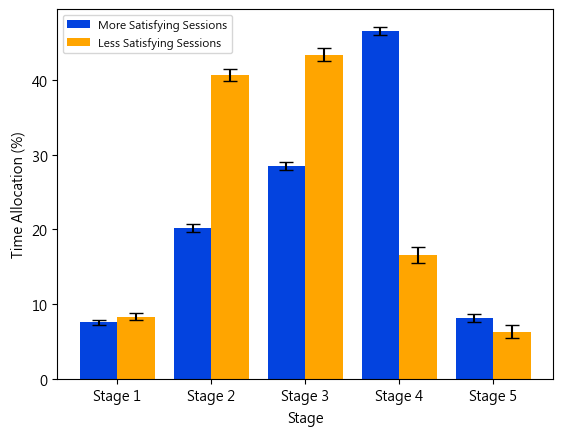

In [573]:
# Step 3: Plot the bar plot with error bars
fig, ax = plt.subplots()

x = np.arange(5)  # X positions for the stages

# Plot bars with error bars
ax.bar(x - 0.2, [ 7.54, 20.16, 28.47, 46.61,  8.16], 0.4, yerr=[0.32, 0.52, 0.53, 0.55, 0.54], color='#0343DF', capsize=5, label='More Satisfying Sessions')
ax.bar(x + 0.2, [ 8.32, 40.72, 43.43, 16.57,  6.29], 0.4, yerr=[0.5 , 0.82, 0.87, 1.03, 0.9 ], color='orange', capsize=5, label='Less Satisfying Sessions')

# Add labels and title
ax.set_xticks(x)
ax.set_xticklabels(['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 5'])
ax.set_xlabel('Stage')
ax.set_ylabel('Time Allocation (%)')
# ax.set_title('Time Allocation by Stage (with Standard Error)')
ax.legend(fontsize=8, loc="upper left")

plt.show()